In [1]:
from pathlib import Path
import os
import shutil
import random
from tqdm import tqdm
import time
from glob import glob
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
import torchvision.models as models
import torch.nn.functional as F


from google.colab import drive

In [2]:
# drive.mount('/content/drive')

In [3]:
# os.makedirs('/root/.kaggle', exist_ok=True)

# shutil.copy("/content/drive/My Drive/kaggle json/kaggle.json", "/root/.kaggle/kaggle.json")
# 

In [4]:
# !pip install opendatasets

In [5]:
# import opendatasets as od

In [6]:
# od.download("https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c")

In [7]:
root_dir = '/kaggle/input/brain-tumor-mri-images-44c'

In [8]:
dataset = datasets.ImageFolder(root_dir)

In [9]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

In [10]:
train, test = random_split(dataset, [train_size, val_size])

In [11]:
import torchvision.transforms as transforms

# Training Data Transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),   
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(15), 
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


In [12]:
class Brain44(torch.utils.data.Dataset):
    def __init__(self, subset, transform, class_names):
        self.subset = subset
        self.transform = transform
        self.class_names = class_names

    def __getitem__(self, index):
        img, label = self.subset[index]
        img_transformed = self.transform(img)
        return img_transformed, label

    def __len__(self):
        return len(self.subset)

    def plot_sample_images(self, num_images=5, cols=5):
        num_images = min(num_images, len(self.subset))
        img_indices = random.sample(range(len(self.subset)), num_images)

        cols = min(cols, num_images)
        rows = (num_images + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3))
        axes = axes.flatten()

        for i, idx in enumerate(img_indices):
            img, label = self.subset[idx]
            class_name = self.class_names[label]
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Label: \n{class_name}")

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.show()

    def plot_transformed_images(self, num_images=5):
        num_images = min(num_images, len(self.subset))
        img_indices = random.sample(range(len(self.subset)), num_images)

        for idx in img_indices:
            fig, axes = plt.subplots(1, 2, figsize=(6, 3))

            img, label = self.subset[idx]
            transformed_img = self.transform(img)
            class_name = self.class_names[label]

            transformed_img = transformed_img.permute(1, 2, 0).numpy()

            axes[0].imshow(img)
            axes[0].axis("off")
            axes[0].set_title(f"Original ({class_name})")

            axes[1].imshow(transformed_img)
            axes[1].axis("off")
            axes[1].set_title(f"Transformed ({class_name})")

            plt.show()

In [13]:
class_names = dataset.classes



In [14]:
train_dataset = Brain44(train, train_transform, class_names)
test_dataset = Brain44(test, test_transform, class_names)

In [15]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
class_names = dataset.classes
class_to_idx = dataset.class_to_idx

print("Classes:", class_names)
print("len of Classes:", len(class_names))
print("Class-to-Index Mapping:", class_to_idx)
print("Train set size:", len(train_dataset))
print("test set size:", len(test_dataset))

Classes: ['Astrocitoma T1', 'Astrocitoma T1C+', 'Astrocitoma T2', 'Carcinoma T1', 'Carcinoma T1C+', 'Carcinoma T2', 'Ependimoma T1', 'Ependimoma T1C+', 'Ependimoma T2', 'Ganglioglioma T1', 'Ganglioglioma T1C+', 'Ganglioglioma T2', 'Germinoma T1', 'Germinoma T1C+', 'Germinoma T2', 'Glioblastoma T1', 'Glioblastoma T1C+', 'Glioblastoma T2', 'Granuloma T1', 'Granuloma T1C+', 'Granuloma T2', 'Meduloblastoma T1', 'Meduloblastoma T1C+', 'Meduloblastoma T2', 'Meningioma T1', 'Meningioma T1C+', 'Meningioma T2', 'Neurocitoma T1', 'Neurocitoma T1C+', 'Neurocitoma T2', 'Oligodendroglioma T1', 'Oligodendroglioma T1C+', 'Oligodendroglioma T2', 'Papiloma T1', 'Papiloma T1C+', 'Papiloma T2', 'Schwannoma T1', 'Schwannoma T1C+', 'Schwannoma T2', 'Tuberculoma T1', 'Tuberculoma T1C+', 'Tuberculoma T2', '_NORMAL T1', '_NORMAL T2']
len of Classes: 44
Class-to-Index Mapping: {'Astrocitoma T1': 0, 'Astrocitoma T1C+': 1, 'Astrocitoma T2': 2, 'Carcinoma T1': 3, 'Carcinoma T1C+': 4, 'Carcinoma T2': 5, 'Ependimom

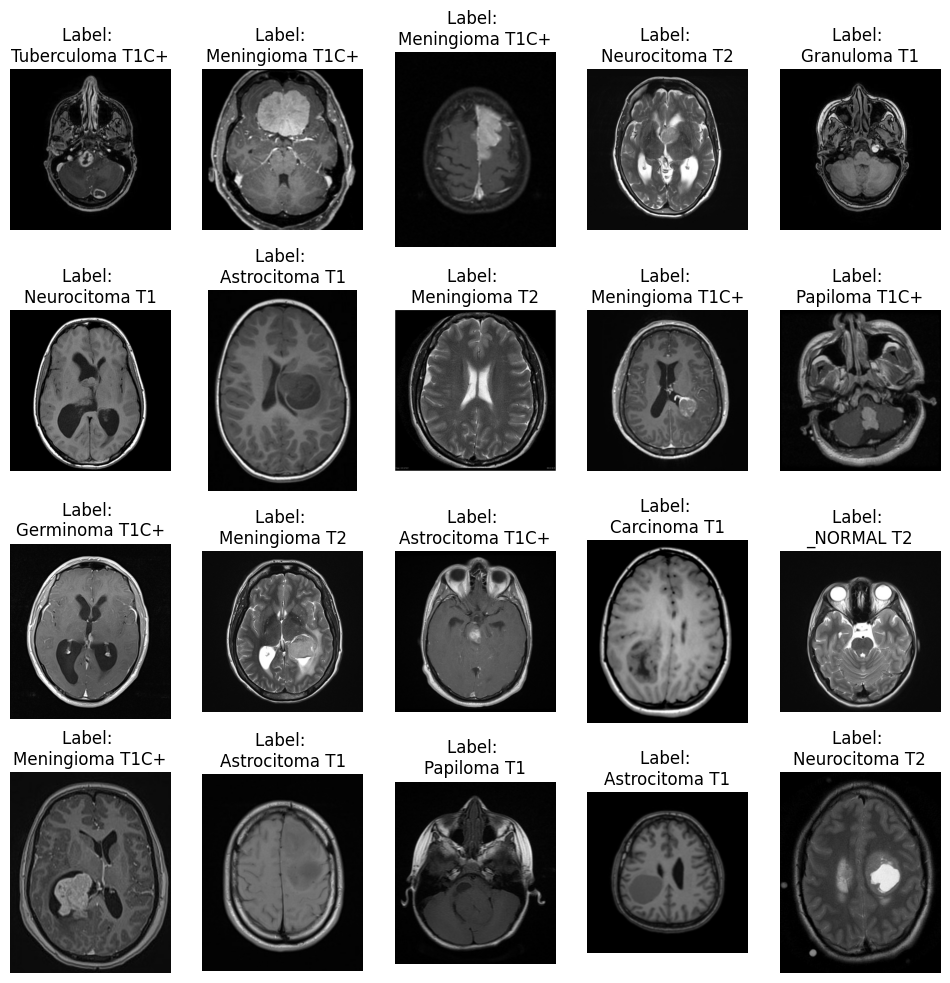

In [17]:
train_dataset.plot_sample_images(num_images=20)


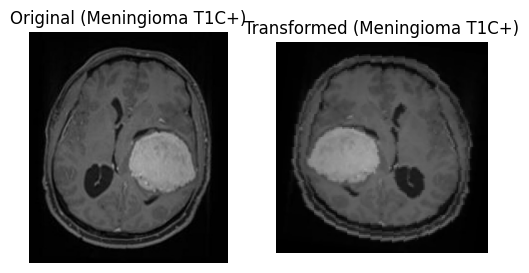

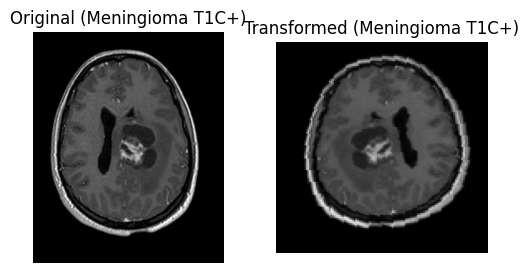

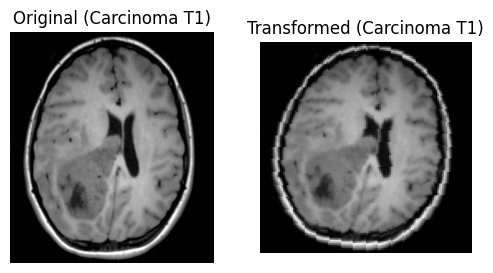

In [18]:
train_dataset.plot_transformed_images(num_images=3)

In [19]:
class BrainTumorEfficientNet(nn.Module):
    def __init__(self, num_classes=44):
        super(BrainTumorEfficientNet, self).__init__()
        
        self.base_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.base_model.classifier = nn.Identity() 
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1536),
            nn.Linear(1536, 256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1) 
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x


num_classes = 44
model = BrainTumorEfficientNet(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adamax(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

from torchsummary import summary
summary(model, (3, 224, 224))


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 189MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 112, 112]           1,080
       BatchNorm2d-2         [-1, 40, 112, 112]              80
              SiLU-3         [-1, 40, 112, 112]               0
            Conv2d-4         [-1, 40, 112, 112]             360
       BatchNorm2d-5         [-1, 40, 112, 112]              80
              SiLU-6         [-1, 40, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12         [-1, 40, 112, 112]               0
           Conv2d-13         [-1, 24, 112, 112]             960
      BatchNorm2d-14         [-1, 24, 1

In [20]:

def acc_fn(y_pred, y_true):
    return (y_pred == y_true).sum().item() / len(y_true)

In [21]:


def train_step(model, dataloader, loss_fn, acc_fn, optimizer, device):
  size = len(dataloader.dataset)
  batch_size = len(dataloader)
  model.train()
  train_loss, train_acc = 0, 0
  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    acc = acc_fn(y_pred.argmax(dim=1), y)
    train_acc += acc

  return train_acc / batch_size, train_loss / batch_size



In [22]:
def test_step(model, dataloader, loss_fn, acc_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_acc = 0.0, 0.0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            acc = acc_fn(y_pred.argmax(dim=1), y)
            test_acc += acc

    return test_acc / num_batches, test_loss / num_batches

In [23]:

def trainx(model, train_dataloader, test_dataloader, loss_fn, acc_fn, optimizer, scheduler, device, epochs, save_path="brain_tumor_model.pth"):
    train_acc_list, test_acc_list = [], []
    train_loss_list, test_loss_list = [], []

    for epoch in range(epochs):
        train_acc, train_loss = train_step(model, train_dataloader, loss_fn, acc_fn, optimizer, device)
        test_acc, test_loss = test_step(model, test_dataloader, loss_fn, acc_fn, device)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss)

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(test_loss) 
        else:
            scheduler.step() 

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

        if (epoch + 1) % 4 == 0:
            model_filename = f"{save_path}_epoch{epoch+1}.pth"
            torch.save(model.state_dict(), model_filename)
            print(f"Model saved at epoch {epoch+1}: {model_filename}")

    return train_acc_list, test_acc_list, train_loss_list, test_loss_list


In [24]:
epochs = 20
train_acc_list, test_acc_list, train_loss_list, test_loss_list= trainx(model, train_loader, test_loader, criterion, acc_fn, optimizer, scheduler, device, epochs)

Epoch 1: Train Acc: 0.3386, Train Loss: 2.5928 | Test Acc: 0.6027, Test Loss: 1.5836
Epoch 2: Train Acc: 0.6280, Train Loss: 1.4126 | Test Acc: 0.7132, Test Loss: 0.9918
Epoch 3: Train Acc: 0.7443, Train Loss: 0.9371 | Test Acc: 0.7991, Test Loss: 0.6780
Epoch 4: Train Acc: 0.8269, Train Loss: 0.6237 | Test Acc: 0.8460, Test Loss: 0.5101
Model saved at epoch 4: brain_tumor_model.pth_epoch4.pth
Epoch 5: Train Acc: 0.8783, Train Loss: 0.4258 | Test Acc: 0.8850, Test Loss: 0.3964
Epoch 6: Train Acc: 0.9188, Train Loss: 0.2858 | Test Acc: 0.9219, Test Loss: 0.2878
Epoch 7: Train Acc: 0.9406, Train Loss: 0.2266 | Test Acc: 0.9252, Test Loss: 0.2523
Epoch 8: Train Acc: 0.9534, Train Loss: 0.1870 | Test Acc: 0.9308, Test Loss: 0.2385
Model saved at epoch 8: brain_tumor_model.pth_epoch8.pth
Epoch 9: Train Acc: 0.9626, Train Loss: 0.1405 | Test Acc: 0.9353, Test Loss: 0.2096
Epoch 10: Train Acc: 0.9654, Train Loss: 0.1302 | Test Acc: 0.9386, Test Loss: 0.2010
Epoch 11: Train Acc: 0.9726, Train 

In [25]:
for param_group in optimizer.param_groups:
    print(f"Learning Rate: {param_group['lr']}")
    print(f"Weight Decay: {param_group.get('weight_decay', 0)}")

Learning Rate: 6.25e-05
Weight Decay: 0


In [26]:

def plot_metrics(train_acc, test_acc, train_loss, test_loss, epochs):
    fig, ax1 = plt.subplots(figsize=(8,5))

    # Left y-axis (Accuracy)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color='tab:blue')
    ax1.plot(range(1, epochs+1), train_acc, 'o-', label="Train Accuracy", color='tab:blue')
    ax1.plot(range(1, epochs+1), test_acc, 's-', label="Test Accuracy", color='tab:cyan')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('Loss', color='tab:red')
    ax2.plot(range(1, epochs+1), train_loss, 'o--', label="Train Loss", color='tab:red')
    ax2.plot(range(1, epochs+1), test_loss, 's--', label="Test Loss", color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.suptitle('Training & Testing Accuracy and Loss')
    fig.legend(loc="upper center", bbox_to_anchor=(0.7, 0.55), ncol=2)

    plt.show()

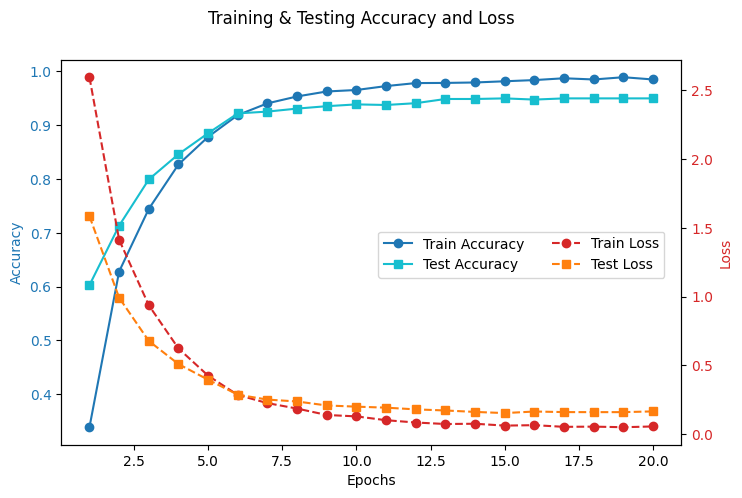

In [27]:
plot_metrics(train_acc_list, test_acc_list, train_loss_list, test_loss_list, epochs)

In [28]:

class BrainTumorEfficientNet(nn.Module):
    def __init__(self, num_classes=44):
        super(BrainTumorEfficientNet, self).__init__()
        
        self.base_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.base_model.classifier = nn.Identity()  
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1536),
            nn.Linear(1536, 256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)  
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorEfficientNet(num_classes=44).to(device)

model.load_state_dict(torch.load("/kaggle/working/brain_tumor_model.pth_epoch20.pth", map_location=device))
model.eval() 

<ipython-input-28-63a2914d25f7>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/brain_tumor_model.pth_epoch20.pth", map_l

BrainTumorEfficientNet(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
      

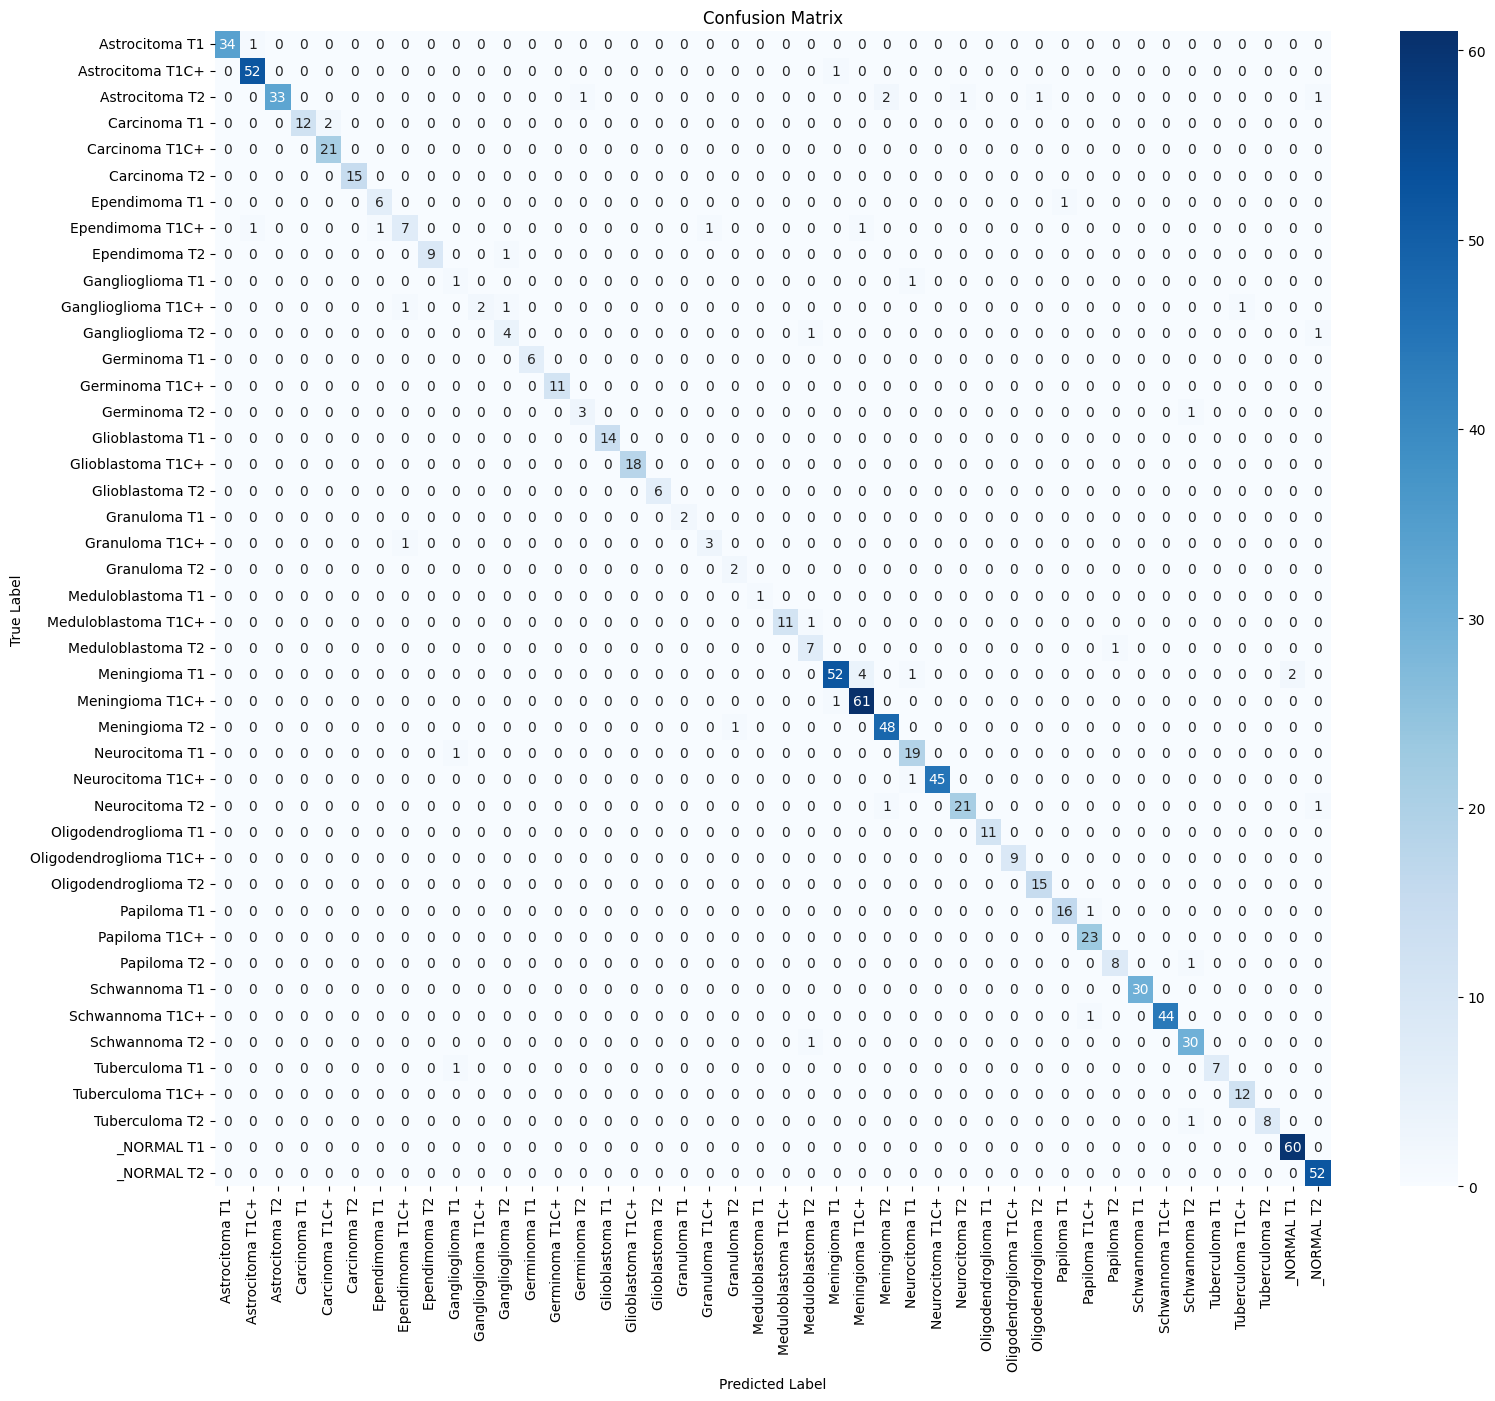

In [29]:
from sklearn.metrics import confusion_matrix
class_names =dataset.classes
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12 * 1.5, 10 * 1.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90) 
plt.yticks(rotation=0)
plt.show()


In [30]:

class BrainTumorEfficientNet(nn.Module):
    def __init__(self, num_classes=44):
        super(BrainTumorEfficientNet, self).__init__()
        
        self.base_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.base_model.classifier = nn.Identity()  
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1536),
            nn.Linear(1536, 256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)  
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorEfficientNet(num_classes=44).to(device)

model.load_state_dict(torch.load("/kaggle/working/brain_tumor_model.pth_epoch20.pth", map_location=device))
model.eval() 


def predict_image(image_path, model, class_names, device):
    transform = transforms.Compose([
    transforms.Resize((128, 128)),   
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(15),  
    transforms.ToTensor(),
])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device) 

    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)

    return class_names[predicted_class.item()]  


<ipython-input-30-07a032d848fd>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/brain_tumor_model.pth_epoch20.pth", map_l

In [31]:
model.eval()
image_path = "/kaggle/input/brain-tumor-mri-images-44c/Germinoma T1C+/2022-06-10 13_57_31-Pineal germinoma _ Radiology Case _ Radiopaedia.org.jpg" 
predicted_label = predict_image(image_path, model, class_names, device)
print(f"Predicted Class: {predicted_label}")

Predicted Class: Germinoma T1C+
